In [64]:
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import cv2
from keras.utils import load_img, img_to_array
import tensorflow as tf

from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
import numpy as np
import pickle

from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras_vggface import utils
from tensorflow.keras.models import Model


headshots_folder_name = 'Headshots'

# dimension of images
image_width = 224
image_height = 224

# for detecting faces
facecascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# set the directory containing the images
images_dir = os.path.join(".", headshots_folder_name)

current_id = 0
label_ids = {}

# iterates through all the files in each subdirectories
for root, _, files in os.walk(images_dir):
    for file in files:
        if file.endswith("jpg"):
            # path of the image
            path = os.path.join(root, file)

            # get the label name (name of the person)
            label = os.path.basename(root).replace(" ", ".").lower()

            # add the label (key) and its number (value)
            if not label in label_ids:
                label_ids[label] = current_id
                current_id += 1

            # load the image
            imgtest = cv2.imread(path, cv2.IMREAD_COLOR)
            image_array = np.array(imgtest, "uint8")

            # get the faces detected in the image
            faces = facecascade.detectMultiScale(imgtest,
                scaleFactor=1.1, minNeighbors=5)

            # if not exactly 1 face is detected, skip this photo
            if len(faces) != 1:
                print(f'---Photo skipped---\n')
            # remove the original image
                os.remove(path)
                continue

            # save the detected face(s) and associate
            # them with the label
            for (x_, y_, w, h) in faces:

                # draw the face detected
                face_detect = cv2.rectangle(imgtest,
                        (x_, y_),
                        (x_+w, y_+h),
                        (255, 0, 255), 2)
                # plt.imshow(face_detect)
                # plt.show()

                # resize the detected face to 224x224
                size = (image_width, image_height)

                # detected face region
                roi = image_array[y_: y_ + h, x_: x_ + w]

                # resize the detected head to target size
                resized_image = cv2.resize(roi, size)
                image_array = np.array(resized_image, "uint8")

                # remove the original image
                os.remove(path)

                # replace the image with only the face
                im = Image.fromarray(image_array)
                im.save(path)


---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---

---Photo skipped---



In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory('./Headshots',
target_size=(224,224),
color_mode='rgb',
batch_size=32,
class_mode='categorical',
shuffle=True)

Found 62 images belonging to 4 classes.


In [5]:
train_generator.class_indices.values()
# dict_values([0, 1, 2])
NO_CLASSES = len(train_generator.class_indices.values())
NO_CLASSES

4

In [6]:


base_model = VGGFace(include_top=True,
    model='vgg16',
    input_shape=(224, 224, 3))
base_model.summary()

print(len(base_model.layers))
# 26 layers in the original VGG-Face

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [7]:
base_model = VGGFace(include_top=False,
model='vgg16',
input_shape=(224, 224, 3))
base_model.summary()
print(len(base_model.layers))
# 19 layers after excluding the last few layers

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [48]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# final layer with softmax activation
preds = Dense(NO_CLASSES , activation='softmax')(x)


In [49]:
# create a new model with the base model's original input and the 
# new model's output
model = Model(inputs = base_model.input, outputs = preds)
model.summary()

# don't train the first 19 layers - 0..18
for layer in model.layers[:19]:
    layer.trainable = False

# train the rest of the layers - 19 onwards
for layer in model.layers[19:]:
    layer.trainable = True


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [50]:
model.compile(optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])


In [51]:
model.fit(train_generator,
  batch_size = 1,
  verbose = 1,
  epochs = 20)


Epoch 1/20
2/2 [==============================] - 10s 4s/step - loss: 1.3600 - accuracy: 0.4032
Epoch 2/20
2/2 [==============================] - 7s 3s/step - loss: 1.1516 - accuracy: 0.8387
Epoch 3/20
2/2 [==============================] - 6s 3s/step - loss: 0.8440 - accuracy: 0.8387
Epoch 4/20
2/2 [==============================] - 6s 3s/step - loss: 0.4831 - accuracy: 0.8548
Epoch 5/20
2/2 [==============================] - 6s 3s/step - loss: 0.2105 - accuracy: 1.0000
Epoch 6/20
2/2 [==============================] - 7s 3s/step - loss: 0.0833 - accuracy: 1.0000
Epoch 7/20
2/2 [==============================] - 7s 3s/step - loss: 0.0271 - accuracy: 1.0000
Epoch 8/20
2/2 [==============================] - 7s 3s/step - loss: 0.0094 - accuracy: 1.0000
Epoch 9/20
2/2 [==============================] - 7s 3s/step - loss: 0.0027 - accuracy: 1.0000
Epoch 10/20
2/2 [==============================] - 7s 3s/step - loss: 5.5440e-04 - accuracy: 1.0000
Epoch 11/20
2/2 [===========================

In [52]:
# creates a HDF5 file
model.save(
    'transfer_learning_trained' +
    '_face_cnn_model.h5')


In [53]:


# deletes the existing model
del model

# returns a compiled model identical to the previous one
model = load_model(
    'transfer_learning_trained' +
    '_face_cnn_model.h5')


In [54]:


class_dictionary = train_generator.class_indices
class_dictionary = {
    value:key for key, value in class_dictionary.items()
}
print(class_dictionary)


{0: 'Abhay', 1: 'Harshit', 2: 'Mahin', 3: 'Vishal'}


In [55]:
# save the class dictionary to pickle
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, 'wb') as f: pickle.dump(class_dictionary, f)


In [56]:



# dimension of images
image_width = 224
image_height = 224

# load the training labels
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, "rb") as \
    f: class_dictionary = pickle.load(f)

class_list = [value for _, value in class_dictionary.items()]
print(class_list)


['Abhay', 'Harshit', 'Mahin', 'Vishal']


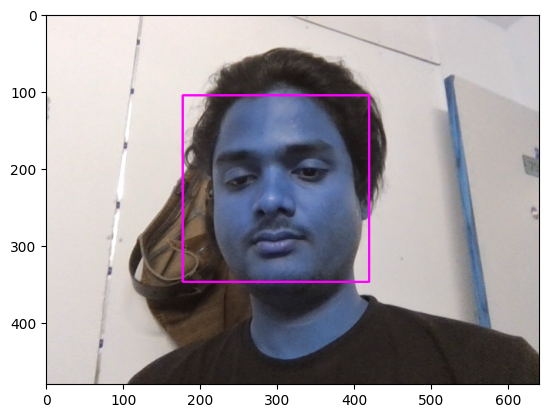

1/1 [==============================] - 0s 371ms/step
[[1. 0. 0. 0.]]
tf.Tensor([0.47536692 0.17487772 0.17487772 0.17487772], shape=(4,), dtype=float32)
0
Predicted face: Abhay



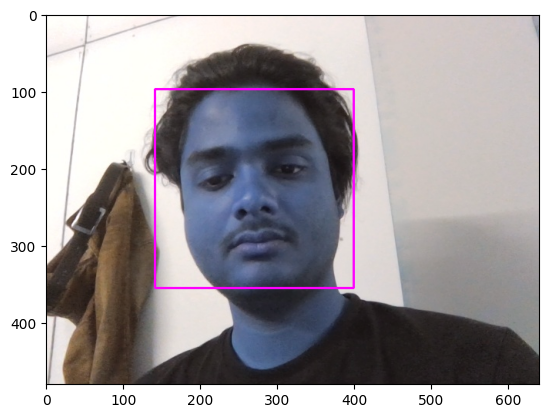

1/1 [==============================] - 0s 173ms/step
[[1. 0. 0. 0.]]
tf.Tensor([0.47536692 0.17487772 0.17487772 0.17487772], shape=(4,), dtype=float32)
0
Predicted face: Abhay



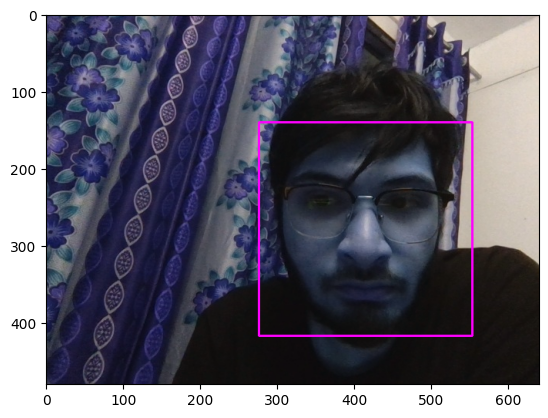

1/1 [==============================] - 0s 170ms/step
[[0. 0. 1. 0.]]
tf.Tensor([0.17487772 0.17487772 0.47536692 0.17487772], shape=(4,), dtype=float32)
2
Predicted face: Mahin



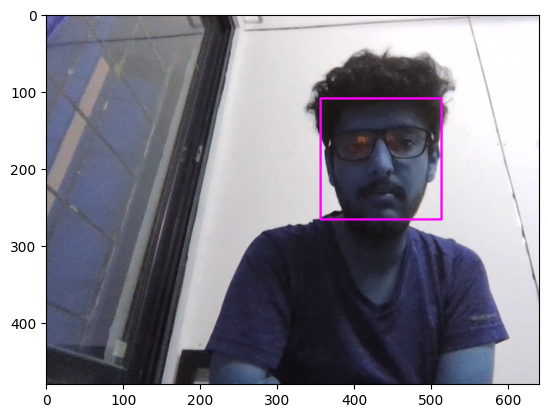

1/1 [==============================] - 0s 177ms/step
[[0. 1. 0. 0.]]
tf.Tensor([0.17487772 0.47536692 0.17487772 0.17487772], shape=(4,), dtype=float32)
1
Predicted face: Harshit



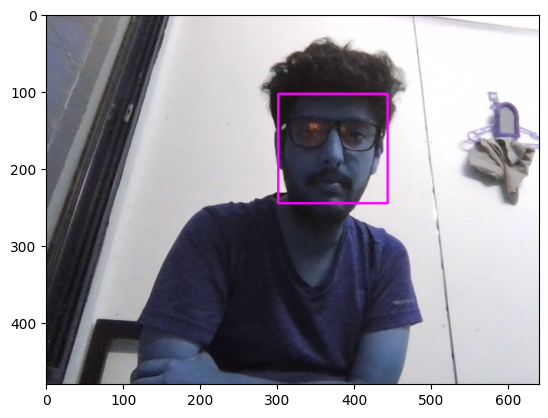

1/1 [==============================] - 0s 149ms/step
[[0. 1. 0. 0.]]
tf.Tensor([0.17487772 0.47536692 0.17487772 0.17487772], shape=(4,), dtype=float32)
1
Predicted face: Harshit



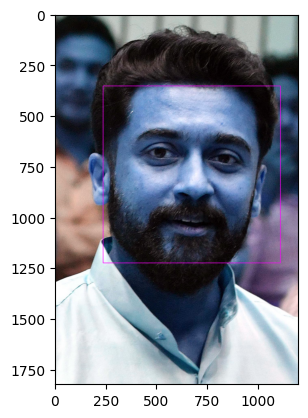

1/1 [==============================] - 0s 167ms/step
[[0. 1. 0. 0.]]
tf.Tensor([0.17487772 0.47536692 0.17487772 0.17487772], shape=(4,), dtype=float32)
1
Predicted face: Harshit



In [60]:


# # deletes the existing model
# del model

# returns a compiled model identical to the previous one
model = load_model(
    'transfer_learning_trained' +
    '_face_cnn_model.h5')

image_width = 224
image_height = 224

facecascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

for i in range(1,9): 
    test_image_filename = f'./facetest/face{i}.jpg'

    # load the image
    imgtest = cv2.imread(test_image_filename, cv2.IMREAD_COLOR)
    image_array = np.array(imgtest, "uint8")

    # get the faces detected in the image
    faces = facecascade.detectMultiScale(imgtest, 
        scaleFactor=1.1, minNeighbors=5)

    # if not exactly 1 face is detected, skip this photo
    if len(faces) != 1: 
        # print(f'---We need exactly 1 face;photo skipped---')
        # print()
        continue

    for (x_, y_, w, h) in faces:
        # draw the face detected
        face_detect = cv2.rectangle(
            imgtest, (x_, y_), (x_+w, y_+h), (255, 0, 255), 2)
        plt.imshow(face_detect)
        plt.show()

        # resize the detected face to 224x224
        size = (image_width, image_height)
        roi = image_array[y_: y_ + h, x_: x_ + w]
        resized_image = cv2.resize(roi, size)

        # prepare the image for prediction
        x = img_to_array(resized_image)
        x = np.expand_dims(x, axis=0)
        x = utils.preprocess_input(x, version=1)

        # making prediction
        predicted_prob = model.predict(x)
        print(predicted_prob)
        print(tf.nn.softmax(predicted_prob[0]))
        print(predicted_prob[0].argmax())
        print("Predicted face: " + class_list[predicted_prob[0].argmax()])
        print("============================\n")


In [62]:
from PIL import Image
import numpy as np
import cv2
import pickle
from tensorflow.keras.models import load_model

# for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# resolution of the webcam
screen_width = 1280       # try 640 if code fails
screen_height = 720

# size of the image to predict
image_width = 224
image_height = 224

# load the trained model
model = load_model('transfer_learning_trained_face_cnn_model.h5')

# the labels for the trained model
with open("face-labels.pickle", 'rb') as f:
    og_labels = pickle.load(f)
    labels = {key:value for key,value in og_labels.items()}
    print(labels)

# default webcam
stream = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    (grabbed, frame) = stream.read()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # try to detect faces in the webcam
    faces = face_cascade.detectMultiScale(
        rgb, scaleFactor=1.3, minNeighbors=5)

    # for each faces found
    for (x, y, w, h) in faces: 
        roi_rgb = rgb[y:y+h, x:x+w]

        # Draw a rectangle around the face
        color = (255, 0, 0) # in BGR
        stroke = 2
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, stroke)

        # resize the image
        size = (image_width, image_height)
        resized_image = cv2.resize(roi_rgb, size)
        image_array = np.array(resized_image, "uint8")
        img = image_array.reshape(1,image_width,image_height,3) 
        img = img.astype('float32')
        img /= 255

        # predict the image
        predicted_prob = model.predict(img)

        # Display the label
        font = cv2.FONT_HERSHEY_SIMPLEX
        name = labels[predicted_prob[0].argmax()]
        probx = tf.nn.softmax(predicted_prob[0])
        color = (255, 0, 255)
        stroke = 2
        cv2.putText(frame, f'({name}{probx})', (x,y-8),
            font, 0.5, color, stroke, cv2.LINE_AA)

        # Show the frame
        cv2.imshow("Image", frame)
    if cv2.waitKey(1) == 27:
        break 

# Cleanup
stream.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)


{0: 'Abhay', 1: 'Harshit', 2: 'Mahin', 3: 'Vishal'}
1/1 [==============================] - 0s 133ms/step


-1